In [1]:
import numpy as np
import cv2
import tensorflow as tf
print (tf.__version__)
import Dataset
import time
import os
import configparser as ConfigParser
import sys
import argparse 
import psutil
#import  resnet18_linknet as ln
from linknet import *
import matplotlib.pyplot as plt


1.8.0


In [2]:
class Hallucinator ():    
    def __init__ (self,config_file,scale,gpu_num):
        print ("Initializing Hallucinator class")
        tf.reset_default_graph()
        self.scale=scale
        self.gpu ="/gpu:{}".format(gpu_num)
        self.readConfiguration(config_file)
        self.inputs=tf.placeholder(tf.float32,(None,self.imageHeight,self.imageWidth,self.channels),name='Input')             
        self.phase=tf.placeholder(tf.bool,name = "phase")
        self.output  =tf.placeholder(tf.float32,(None,self.imageHeight,self.imageWidth,self.channels),name='grountTruth')
        self.dataObj = Dataset.dataReader(self.dataArguments)
        self.filters = [64, 128, 256, 512]
        self.filters_m = [64, 128, 256, 512][::-1]
        self.filters_n = [64, 64, 128, 256][::-1]
        self.continue_training = True
        if not os.path.exists(self.summary_writer_dir):
            os.makedirs(self.summary_writer_dir)
        if not os.path.exists(self.modelLocation):
            os.makedirs(self.modelLocation)
        logPath = os.path.join(self.logDir,self.modelName)
        if not os.path.exists(logPath):
            os.makedirs(logPath)
        self.logDir = os.path.join(logPath,'log.txt')
        try :
            os.remove(self.logDir)
        except :
            pass
        
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_num)
        self.teacherScope = "Teacher"
        self.generatorScope = "Generator"
        self.sess = None
        with open(config_file) as fh :
            self.confInfo = fh.read()        
                
        if self.model_choice == "APG" :
            self.model = self.generateImage()
            
    def readConfiguration(self,config_file):
        print ("Reading configuration File")
        config = ConfigParser.ConfigParser()
        config.read(config_file)
        self.imageWidth=int(int(config.get('DATA','imageWidth'))/self.scale)
        self.imageHeight=int(int(config.get('DATA','imageHeight'))/self.scale)
        self.channels=int (config.get('DATA','channels'))
        self.train_file = config.get ('DATA','train_file')
        self.test_file  = config.get ('DATA','test_file')
        autoencoder_train_file = config.get('DATA','autoencoder_train_file')
        autoencoder_test_file  = config.get('DATA','autoencoder_test_file')
        self.batchSize  = int(config.get ('DATA','batchSize'))
        self.colorLossType= config.get('DATA','colorLossType')
        self.corruptionLevel =float(config.get('DATA','corruptionLevel'))
        self.dataArguments = {"imageWidth":self.imageWidth,"imageHeight":self.imageHeight,"channels" : self.channels, "batchSize":self.batchSize,"train_file":self.train_file,"test_file":self.test_file,"scale":self.scale,"colorSpace":self.colorLossType,"corruptionLevel":self.corruptionLevel,"autoencoder_train_file": autoencoder_train_file,"autoencoder_test_file": autoencoder_test_file}    
        self.maxEpoch=int(config.get('TRAIN','maxEpoch'))
        self.generatorLearningRate = float(config.get('TRAIN','generatorLearningRate'))
        self.teacherLearningRate =  float (config.get('TRAIN','teacherLearningRate'))
        self.huberDelta  = float(config.get('TRAIN','huberDelta'))
        self.lambda1     = float(config.get('TRAIN','rmse_lambda'))
        self.lambda2     = float(config.get('TRAIN','smooth_lambda'))
        self.lambda3     = float(config.get('TRAIN','colorLoss_lambda'))
        self.model_choice = config.get('TRAIN','model')
        self.dropout_probability   = config.get('TRAIN', 'dropout')
        self.restore_name = config.get('LOG','restoreModelName')
        self.restoreModelPath = config.get('LOG','restoreModelPath')
        
        if int(config.get('TRAIN','activation')) == 0:
            self.activation = tf.nn.relu
            print("Relu activation has been chosen")
        else :
            self.activation = tf.nn.selu
        self.normType = config.get('TRAIN',"normalizationType")
        print (self.normType + " Normalization has been chosen")
        self.print_freq=int(config.get('LOG','print_freq'))
        self.save_freq = int (config.get('LOG','save_freq'))
        self.val_freq = int (config.get('LOG','val_freq'))
        self.modelName = config.get('LOG','modelName') +"_s{}".format(self.scale)
        self.modelLocation = config.get('LOG','modelLocation')
        self.modelLocation = os.path.join(self.modelLocation , self.modelName)
        self.checkPoint =  bool(int(config.get('LOG','checkpoint')))
        #self.restoreModelPath =config.get('LOG','restoreModelPath')
        self.logDir = config.get('LOG','logFile')
        self.summary_writer_dir =os.path.join(config.get('LOG','summary_writer_dir') ,self.modelName)    
        
        
    def normalization(self,feat,typeN):
        if typeN == "BATCH":
            return tf.layers.batch_normalization(feat, training = self.phase)
        if typeN == "INSTANCE":
            return tf.contrib.layers.instance_norm(feat)
    
    def train(self,trainModel): 
        #tf.reset_default_graph()
        
        if os.path.isfile (self.logDir):
            print ("This log file with same name exisits. Likely that the model file exists. If you want to cancel, cancel in the next 5 seconds")
            time.sleep(5)
            self.logger = open(self.logDir,'a')
        else :
            self.logger = open(self.logDir,'w')
            self.logger.write(trainModel + " Training")
            self.logger.write("***********************")
            self.logger.write(self.confInfo +'\n\n\n')
        
        if trainModel == 'TEACHER':
            print ("The teacher is being trained right now ")
            if self.continue_training :
                self.restoreModel("TEACHER")
            else :                
                with tf.variable_scope(self.teacherScope):
                    self.outH,self.teacherEndpoints = linknet(self.inputs,num_classes =3,reuse = None,is_training = self.phase)
                self.variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope = self.teacherScope) 
                self.update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS,scope = self.teacherScope)
            loss= self.autoEncoderLoss()
            
            learningRate = self.teacherLearningRate
            dataGrabber = self.dataObj.nextAutoencoderTrainBatch
            dataGrabberTest = self.dataObj.nextAutoencoderTestBatch
            
            
        elif trainModel == 'GENERATOR':
            print ("The Generator model is being trained right now")
            #self.restoreModel("TEACHER")
            #outH2 = self.outH
            if self.continue_training :
                self.restoreModel("GENERATOR")
                
            else :
                with tf.variable_scope(self.generatorScope):
                    self.outH,self.generatorEndpoints = linknet(self.inputs,num_classes =3,reuse = None,is_training = self.phase)#linkNet.build_model()
                self.variables  = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope = self.generatorScope)
                self.update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS,scope = self.generatorScope) 
            
            loss = self.loss()
            learningRate = self.generatorLearningRate
            dataGrabber = self.dataObj.nextTrainBatch
            dataGrabberTest = self.dataObj.nextTestBatch
    
        else :
            print ("Invalid model choice")
            return None
    
        optimizer=tf.train.AdamOptimizer(learning_rate=learningRate)
        with tf.control_dependencies(self.update_ops): 
            Trainables=optimizer.minimize(loss,var_list = self.variables)
        valid_image_summary =tf.summary.image('test_image_output',self.outH)
        loss_summary = tf.summary.scalar('Loss',loss)
        iters=0
        
        self.saver = tf.train.Saver(var_list = self.variables) 
        config=tf.ConfigProto()
        config.gpu_options.allow_growth=True
        self.sess = tf.Session(config=config)
        train_summary_writer=tf.summary.FileWriter(os.path.join(self.summary_writer_dir,trainModel+'train'),self.sess.graph)
        test_summary_writer=tf.summary.FileWriter(os.path.join(self.summary_writer_dir,trainModel+'test'),self.sess.graph)
        self.sess.run(tf.global_variables_initializer())
        if self.continue_training:
            self.saver.restore(self.sess,self.restoreModelPath)
        process = psutil.Process(os.getpid())
        self.dataObj.resetTrainBatch()
        self.dataObj.resetTestBatch()
        
            
        
            
        while not self.dataObj.epoch == self.maxEpoch :
            t1=time.time()
            inp,gt =dataGrabber(True)
#             import matplotlib.pyplot as plt 
#             plt.imshow(np.uint8(inp[0]))
#             plt.figure()
#             plt.imshow(np.uint8(gt[0]))
#             s
            _,lval,t_summaries= self.sess.run([Trainables,loss,loss_summary], feed_dict= {self.inputs : inp,self.output : gt,self.phase : True})        
#             import matplotlib.pyplot as plt 
#             plt.imshow(np.uint8(output_tmp[0]))
#             s
            t2=time.time()      
            if not iters % self.print_freq:
                info = "Model Hallucinator_s{} Epoch  {} : Iteration : {}/{} loss value : {:0.4f} \n".format(self.scale,self.dataObj.epoch,iters,(self.maxEpoch)*int(self.dataObj.dataLength/self.dataObj.batchSize),lval) +"Memory used : {:0.4f} GB Time per batch : {:0.3f}s Model : {} \n".format(process.memory_info().rss/100000000.,t2-t1,self.modelName) 
                print (info)   
                self.logger.write(info)
                train_summary_writer.add_summary(t_summaries,iters)
                
            if not iters % self.save_freq:
                info="Model Saved at iteration {}\n".format(iters)
                print (info)
                self.logger.write(info)
                self.saveModel(iters,trainModel)
                
            if not iters % self.val_freq :           
                val_inp,val_gt  = dataGrabberTest()
                if trainModel == "TEACHER":
                    val_inp = np.copy(val_gt)
#                 import matplotlib.pyplot as plt 
#                 plt.imshow(np.uint8(val_inp[0]))
#                 plt.figure()
#                 plt.imshow(np.uint8(val_gt[0]))
#                 s
                val_loss,v_summaries,v_img_summaries = self.sess.run([loss,loss_summary,valid_image_summary],feed_dict={self.inputs : val_inp,self.output : val_gt,self.phase:False})  
                test_summary_writer.add_summary(v_summaries, iters)
                test_summary_writer.add_summary(v_img_summaries,iters)
                info = "Validation Loss at iteration{} : {}\n".format(iters, val_loss)
                print (info)
                self.logger.write(info)
            iters+=1
        print ("Training done ")
        self.saveModel(iters,trainModel)
        self.logger.close()
    
    def testAll(self,modelChoice ):
        self.dataObj.resetTestBatch()
        self.restoreModel(modelChoice)
        loss=[]
        if modelChoice == "TEACHER":    
            loss_func = self.autoEncoderLoss()
            dataGrabber = self.dataObj.nextAutoencoderTestBatch
        elif modelChoice == "GENERATOR" :
            loss_func = self.loss()
            corruptionFlag = False
        else : 
            print ("INVALID MODEL CHOICE !!!")
            return None
        print ("Testing")
        while not self.dataObj.test_epoch == 1 :
            x,y = dataGrabber()
            
            if modelChoice == 'TEACHER' :
                print ("---------------------------------------")
                lval= self.sess.run(loss_func, feed_dict= {self.inputs : y,self.output:y, self.phase : False})
            if modelChoice == 'GENERATOR':
                lval= self.sess.run(loss_func, feed_dict= {self.inputs : x ,self.phase : False ,self.output : y})
            loss.append(lval)
            print("Test start : {} Model: {} Test Loss : {}".format(self.dataObj.test_start,self.modelName,lval))
        return np.mean(loss)
        
    def getHallucinatedImages(self,image_list):
        if self.sess is None:
            self.restoreModel("GENERATOR")
        img_processed= self.dataObj.loadImages(image_list,False)
#         img_processed = cv2.imread(image_list[0],-1)
#         img_processed = np.uint8((img_processed/np.max(img_processed))*255.)
#         img_processed = cv2.resize(np.stack([img_processed,img_processed,img_processed],axis=-1),(640,480))
#         plt.imshow(img_processed)
#         img_processed = np.float32([img_processed])   
#         img_processed = img_processed.reshape(-1,480,640,3)
        output = self.sess.run(self.outH,{self.inputs:img_processed,self.phase : False})
        output = self.dataObj.postProcessImages(output)
        return output
    
    def getTeacherImages(self,image_list):
        self.restoreModel("TEACHER")
        img_processed= self.dataObj.loadImages(image_list)
        #inp,gt = self.dataObj.nextTrainBatch()
        output = self.sess.run(self.outH,{self.inputs:img_processed,self.phase : False})
        output = self.dataObj.postProcessImages(output)
        return output
        
    def getReconstructedImage(self,image):
        img = cv2.imread(image)
        if img is None :
            print ("Not valid image")
            return None
        #img = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
        img = cv2.resize(img,(640,480))
        img = self.dataObj.preProcessImages([img])
        if self.sess is None :
            self.restoreModel("BOTH")
        output = self.sess.run(self.stage1,{self.inputs:img,self.phase : False})
        output = self.sess.run(self.stage2,{self.inputs:output,self.phase : False})
        return self.dataObj.postProcessImages(output)
        
    def loss (self) :
        with tf.variable_scope("Final_loss"):
            return self.lambda1*self.l2_loss() + self.lambda2*self.smoothing_loss() 

    def l2_loss(self):
        with tf.variable_scope ("RMSE_loss"):
            return tf.sqrt(tf.losses.mean_squared_error(self.output,self.outH))  
    
    def autoEncoderLoss(self):
        with tf.variable_scope("Autoencoder_loss"):
            return tf.sqrt(tf.losses.mean_squared_error(self.output,self.outH))  
        
    
    def smoothing_loss(self):
        with tf.variable_scope ("smoothing_loss") :
            I_Hgrad    = tf.image.sobel_edges(self.outH)
            I_Hedge    = I_Hgrad[:,:,:,:,0] + I_Hgrad[:,:,:,:,1]
            zeros      = tf.zeros_like(I_Hedge)
            I_Hhuber   = tf.losses.huber_loss(I_Hedge,zeros,delta = self.huberDelta,reduction=tf.losses.Reduction.NONE)

            I_RGBgrad  = tf.image.sobel_edges(self.output)
            I_RGBedge  = I_RGBgrad[:,:,:,:,0] + I_RGBgrad[:,:,:,:,1]
            I_RGBhuber = tf.losses.huber_loss(I_RGBedge,zeros,delta = self.huberDelta, reduction=tf.losses.Reduction.NONE)

            edge_aware_weight   = tf.exp(-1*I_RGBhuber)
            weighted_smooth_img = tf.multiply(I_Hhuber, edge_aware_weight)
            loss_val = tf.reduce_mean(weighted_smooth_img) 
        return loss_val
    def rmse (self,v1,v2,endPoint):
        return tf.sqrt(tf.losses.mean_squared_error(self.teacherEndpoints[endPoint],self.generatorEndpoints[endPoint]))   
                       
    def featureSpaceLoss (self):
        with tf.variable_scope("Featurespace_loss"):
            feature_loss =\
            rmse("encode1") + rmse("encode2") + rmse("encode3") + rmse("encode4") +\
            rmse ("decode1") + rmse("decode2") + rmse("decode3") + rmse("decode4")
        return feature_loss
            
    def saveModel(self,iters,modelChoice):
        path = os.path.join(self.modelLocation,modelChoice)
        if not os.path.exists (path):
            os.makedirs(path)
        self.saver.save(self.sess,os.path.join(path,modelChoice+'_'+self.modelName),global_step = iters)
                    
    def restoreModel(self,modelChoice):
        path = os.path.join(self.modelLocation,modelChoice)
        if self.checkPoint:
            print ("Using the latest trained model in check point file")
            self.restoreModelPath = tf.train.latest_checkpoint(path)
            print (" Model at {} restored".format(self.restoreModelPath))
        else : 
            
            self.restoreModelPath = os.path.join(self.restoreModelPath,modelChoice,modelChoice+'_'+self.restore_name)
            
        if not self.sess is None:
            if self.sess._opened :
                self.sess.close()
                
        sess=tf.Session()
        if modelChoice == "TEACHER":
            print ("Restoring Teacher model")
            with tf.variable_scope(self.teacherScope):
                self.outH,self.teacherEndpoints = linknet(self.inputs,num_classes =3,reuse = None,is_training = self.phase)
            self.variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope = self.teacherScope) 
            self.update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS,scope = self.teacherScope)
        elif modelChoice == "GENERATOR":
            print ("Restoring Generator model")
            with tf.variable_scope(self.generatorScope):
                self.outH,self.generatorEndpoints = linknet(self.inputs,num_classes =3,reuse = None,is_training = self.phase)
            self.variables =  tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope = self.generatorScope)
            self.update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS,scope = self.generatorScope)
        
        elif modelChoice == "BOTH":
            print ("Restoring Generator and Teacher modelmodel")
            with tf.variable_scope(self.generatorScope):
                self.stage1,self.generatorEndpoints = linknet(self.inputs,num_classes =3,reuse = None,is_training = self.phase)
                variables_gen =  tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope = self.generatorScope)
                update_ops_gen = tf.get_collection(tf.GraphKeys.UPDATE_OPS,scope = self.generatorScope)
            with tf.variable_scope(self.teacherScope):
                self.stage2,self.teacherEndpoints = linknet(self.inputs,num_classes =3,reuse = None,is_training = self.phase)
                variables_teach = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope = self.teacherScope) 
                update_ops_teach = tf.get_collection(tf.GraphKeys.UPDATE_OPS,scope = self.teacherScope)
            
        else :
            print ("INVALID MODEL CHOICE")
            return None
        
        
        if modelChoice == 'BOTH':
            saver = tf.train.Saver(var_list=variables_gen)
            saver.restore(sess,tf.train.latest_checkpoint(os.path.join(self.modelLocation,"GENERATOR")))
            saver = tf.train.Saver(var_list=variables_teach)
            saver.restore(sess,tf.train.latest_checkpoint(os.path.join(self.modelLocation,"TEACHER")))
        else :
            saver=tf.train.Saver(var_list = self.variables)
            saver.restore(sess,self.restoreModelPath)
        self.sess=sess
        
        
    def layerWise1 (self) :
        
        with tf.variable_scope("preTrain_1") :
            eb0 = initial_block(self.inputs, is_training=self.phase,scope='initial_block')
            
            eb1 = encoder_block(eb0, self.filters[0], 3, 1, self.phase,scope='eb1', padding='same')
            
            dbi = decoder_block(eb1, self.filters_m[-1], self.filters_n[-1], 3, 1,is_training=self.phase,scope='db1', padding='same')            
            net = dbi

            net = upconv_bn_relu(net, 32, 3, 2, is_training=self.phase,
                                 scope='conv_transpose')
            net = conv_bn_relu(net, 32, 3, 1, is_training=self.phase,
                               scope='conv')
            # Last layer, no batch normalization or activation
            logits = tf.layers.conv2d_transpose(net, 3 ,kernel_size=2, strides=2,padding='same',name='conv_transpose',kernel_initializer=he_normal())
        
            return  logits
    
        

In [11]:
if __name__=='__main__':
    tf.reset_default_graph()
    H = Hallucinator('config_linknet_teacher_faster_finetune.ini',1,0)
    #print (H.teacherEndpoints.keys())
    #H.restoreModel("BOTH")
    #H.testAll("TEACHER")
    #H.train("GENERATOR")
    #print ("Mean : ",H.testAll())
#     I=H.getReconstructedImage('/home/kgunase3/data/NYUD/Gupta_NYUD/depth_0014.png')
#     I = I[0]
#     I=np.uint8(I)
#     import matplotlib.pyplot as plt 
#     plt.imshow(cv2.cvtColor(I,cv2.COLOR_BGR2RGB))

Initializing Hallucinator class
Reading configuration File
Relu activation has been chosen
BATCH Normalization has been chosen
Initializing Data Reader
Train files 210
Test  files 80
Initialization Complete


Initializing Hallucinator class
Reading configuration File
Relu activation has been chosen
BATCH Normalization has been chosen
Initializing Data Reader
Train files 44625
Test  files 5100
Initialization Complete
Using the latest trained model in check point file
 Model at /home/kgunase3/data/UW/models/rgbHallucination_Fast_UW_stage_1_s1/GENERATOR/GENERATOR_rgbHallucination_Fast_UW_stage_1_s1-27885 restored
Restoring Generator model
INFO:tensorflow:Restoring parameters from /home/kgunase3/data/UW/models/rgbHallucination_Fast_UW_stage_1_s1/GENERATOR/GENERATOR_rgbHallucination_Fast_UW_stage_1_s1-27885
Initializing Hallucinator class
Reading configuration File
Relu activation has been chosen
BATCH Normalization has been chosen
Initializing Data Reader
Train files 44625
Test  files 5100
Initialization Complete
Using the latest trained model in check point file
 Model at None restored
Restoring Generator and Teacher modelmodel
INFO:tensorflow:Restoring parameters from /home/kgunase3/data/UW/m

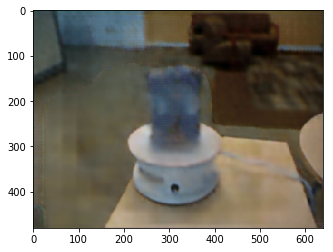

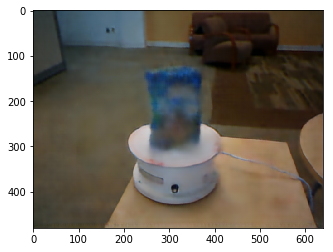

In [3]:
import matplotlib.pyplot as plt
tf.reset_default_graph()
H = Hallucinator('config_linknet_teacher_faster_UW.ini',1,0)
img = H.getHallucinatedImages(['/home/kgunase3/data/rgbd-dataset/food_box/food_box_8/food_box_8_1_217_depth.png'])
i =img[0]
plt.figure()
plt.imshow(cv2.cvtColor(i,cv2.COLOR_BGR2RGB))

tf.reset_default_graph()
H = Hallucinator('config_linknet_teacher_faster_UW.ini',1,0)
img = H.getReconstructedImage('/home/kgunase3/data/rgbd-dataset/food_box/food_box_8/food_box_8_1_217_depth.png') 
i =img[0]
plt.figure()
plt.imshow(cv2.cvtColor(i,cv2.COLOR_BGR2RGB))




In [ ]:
img =cv2.imread('img_5001.png',-1)
img = np.uint8((img/(2**16 -1))*255)
print(img)
plt.imshow(img,cmap='gray')

In [ ]:
import matplotlib.pyplot as plt
tf.reset_default_graph()
H = Hallucinator('config_linknet_teacher_faster.ini',1,0)
img = H.getTeacherImages(['/home/kgunase3/data/NYUD/RAW/RGB/hallucinated_YUV_R_066841.jpg'])
#img = H.getTeacherImages(['/home/kgunase3/Hallucination/src/img_yuv_3.jpg'])
#img2 = H.getHallucinatedImages(['/home/kgunase3/data/NYUD/RAW/Depth/D_121297.jpg'])
#print (len(img))
i =img[0]
#ii = img2[0]
plt.figure()
#cv2.imwrite('img_autoencoder_3.jpg',i)
#cv2.imwrite('img_hallucinated_3.jpg',ii)
plt.imshow(cv2.cvtColor(i,cv2.COLOR_BGR2RGB))
plt.figure()
#plt.imshow(cv2.cvtColor(cv2.imread('/home/kgunase3/Hallucination/src/img_yuv_1.jpg'),cv2.COLOR_YUV2RGB))    
#plt.figure()
#plt.imshow(cv2.cvtColor(ii,cv2.COLOR_BGR2RGB))
#plt.imshow(cv2.cvtColor(i,cv2.COLOR_RGB2YUV))
#plt.figure()
#g = H.dataObj.postProcessImages(g)
#plt.imshow(g[0])
#plt.imshow(cv2.cvtColor(np.uint8(g[0]),cv2.COLOR_BGR2RGB))

In [ ]:
print (mse)

In [ ]:
import skimage

In [ ]:
import tensorflow as tf 
import numpy as np
import cv2
p = tf.placeholder(tf.float32,[None,480,640,3])
k =tf.identity(p)
img = tf.image.sobel_edges(p)
inp = np.float32((cv2.imread('/home/kgunase3/data/NYUD/RAW/RGB/R_099795.jpg')).reshape([-1,480,640,3]))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    out= sess.run([img],feed_dict = {p:inp})[0]
    

In [ ]:
print (out.shape)
out = out[0,:,:,:,0] + out [0,:,:,:,1]
out += np.max(np.abs(out))
out /=np.max(out)
out*=255
out-=np.mean(out)

import matplotlib.pyplot as plt
%matplotlib inline
cv2.imwrite('edge.jpg',np.uint8(out))
plt.imshow(np.uint8(out),cmap ='gray')
plt.figure()
plt.imshow((cv2.imread('/home/kgunase3/data/NYUD/RAW/RGB/R_099795.jpg')))

In [ ]:
print (out)